Code largely taken from the code sample found in Chapter 5, Section 2 of [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python?a_aid=keras&a_bid=76564dff) as well as the associated [Github](https://github.com/fchollet/deep-learning-with-python-notebooks).

## Downloading the data

The cats vs. dogs dataset that we will use isn't packaged with Keras. It was made available by Kaggle.com as part of a computer vision 
competition in late 2013, back when convnets weren't quite mainstream. You can download the original dataset at: 
`https://www.kaggle.com/c/dogs-vs-cats/data` (you will need to create a Kaggle account if you don't already have one -- don't worry, the 
process is painless).

The pictures are medium-resolution color JPEGs. They look like this:

![cats_vs_dogs_samples](https://s3.amazonaws.com/book.keras.io/img/ch5/cats_vs_dogs_samples.jpg)

In [1]:
! wget https://storage.googleapis.com/dhodun-public/cats_dogs/cats_dogs_data.tar.gz

--2018-02-23 03:00:24--  https://storage.googleapis.com/dhodun-public/cats_dogs/cats_dogs_data.tar.gz
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.121.128, 2607:f8b0:4001:c19::80
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.121.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 88852735 (85M) [application/x-tar]
Saving to: ‘cats_dogs_data.tar.gz’

cats_dogs_data.tar. 100%[===================>]  84.74M   158MB/s    in 0.5s    

2018-02-23 03:00:25 (158 MB/s) - ‘cats_dogs_data.tar.gz’ saved [88852735/88852735]



In [2]:
! gsutil cp gs://dhodun-public/cats_dogs/cats_dogs_data.tar.gz ~/ml-teaching-examples/cats_dogs

Copying gs://dhodun-public/cats_dogs/cats_dogs_data.tar.gz...
- [1 files][ 84.7 MiB/ 84.7 MiB]                                                
Operation completed over 1 objects/84.7 MiB.                                     


In [5]:
! tar -xzf cats_dogs_data.tar.gz

Unsurprisingly, the cats vs. dogs Kaggle competition in 2013 was won by entrants who used convnets. The best entries could achieve up to 
95% accuracy. In our own example, we will get fairly close to this accuracy (in the next section), even though we will be training our 
models on less than 10% of the data that was available to the competitors.
This original dataset contains 25,000 images of dogs and cats (12,500 from each class) and is 543MB large (compressed). The dataset we've download has a subset of this: a training set with 1000 samples of each class, a validation 
set with 500 samples of each class, and finally a test set with 500 samples of each class.

In [6]:
import os

base_dir = '/home/dhodun/ml-teaching-examples/cats_dogs'
data_dir = os.path.join(base_dir, 'data')

train_dir = os.path.join(data_dir, 'train')
validation_dir = os.path.join(data_dir, 'validation')
test_dir = os.path.join(data_dir, 'test')

train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')

validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

test_cats_dir = os.path.join(test_dir, 'cats')
test_dogs_dir = os.path.join(test_dir, 'dogs')

In [7]:
print('total training cat images:', len(os.listdir(train_cats_dir)))
print('total validation cat images:', len(os.listdir(validation_cats_dir)))
print('total test cat images:', len(os.listdir(test_cats_dir)))

('total training cat images:', 1000)
('total validation cat images:', 500)
('total test cat images:', 500)


In [8]:
print('total training dog images:', len(os.listdir(train_dogs_dir)))
print('total validation dog images:', len(os.listdir(validation_dogs_dir)))
print('total test dog images:', len(os.listdir(test_dogs_dir)))

('total training dog images:', 1000)
('total validation dog images:', 500)
('total test dog images:', 500)


## Building our network

Our convnet will be a stack of alternated `Conv2D` (with `relu` activation) and `MaxPooling2D` layers.

Note that the depth of the feature maps is progressively increasing in the network (from 32 to 128), while the size of the feature maps is 
decreasing (from 148x148 to 7x7). This is a pattern that you will see in almost all convnets.

Since we are attacking a binary classification problem, we are ending the network with a single unit (a `Dense` layer of size 1) and a 
`sigmoid` activation. This unit will encode the probability that the network is looking at one class or the other.

In [9]:
from keras import models
from keras import layers

model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150,150,3)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

Using TensorFlow backend.


Let's look at the dimensions of each layer and see how space-wise dimensions are decreasing and we learn increasingly detailed features in the feature map.

In [10]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 15, 15, 128)       147584    
__________

In [11]:
from keras import optimizers

model.compile(
    optimizer=optimizers.RMSprop(
        lr=1e-4),
    loss='binary_crossentropy',
    metrics=['acc'])

## Data preprocessing

As you already know by now, data should be formatted into appropriately pre-processed floating point tensors before being fed into our 
network. Currently, our data sits on a drive as JPEG files, so the steps for getting it into our network are roughly:

* Read the picture files.
* Decode the JPEG content to RBG grids of pixels.
* Convert these into floating point tensors.
* Rescale the pixel values (between 0 and 255) to the [0, 1] interval (as you know, neural networks prefer to deal with small input values).

It may seem a bit daunting, but thankfully Keras has utilities to take care of these steps automatically. Keras has a module with image 
processing helper tools, located at `keras.preprocessing.image`. In particular, it contains the class `ImageDataGenerator` which allows to 
quickly set up Python generators that can automatically turn image files on disk into batches of pre-processed tensors. This is what we 
will use here.

In [12]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1. / 255)
test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [13]:
for data_batch, labels_batch in train_generator:
    print('data_batch_shape:', data_batch.shape)
    print('labels_batch_shape:', labels_batch.shape)
    break

('data_batch_shape:', (20, 150, 150, 3))
('labels_batch_shape:', (20,))


Let's fit our model to the data using the generator. We do it using the `fit_generator` method, the equivalent of `fit` for data generators 
like ours. It expects as first argument a Python generator that will yield batches of inputs and targets indefinitely, like ours does. 


In [14]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=50)

# save model
model_dir = os.path.join(base_dir, 'model')
os.mkdir(model_dir)
model.save(model_dir + '/cats_dogs_small_1.h5')

Epoch 1/30
100/100 [==============================] - 9s 85ms/step - loss: 0.6922 - acc: 0.5225 - val_loss: 0.6775 - val_acc: 0.6300
Epoch 2/30
100/100 [==============================] - 7s 68ms/step - loss: 0.6623 - acc: 0.6090 - val_loss: 0.6623 - val_acc: 0.5820
Epoch 3/30
100/100 [==============================] - 7s 67ms/step - loss: 0.6155 - acc: 0.6625 - val_loss: 0.6122 - val_acc: 0.6510
Epoch 4/30
100/100 [==============================] - 7s 68ms/step - loss: 0.5760 - acc: 0.7015 - val_loss: 0.5989 - val_acc: 0.6700
Epoch 5/30
100/100 [==============================] - 7s 68ms/step - loss: 0.5452 - acc: 0.7230 - val_loss: 0.5935 - val_acc: 0.6750
Epoch 6/30
100/100 [==============================] - 7s 68ms/step - loss: 0.5150 - acc: 0.7420 - val_loss: 0.5594 - val_acc: 0.6980
Epoch 7/30
100/100 [==============================] - 7s 68ms/step - loss: 0.4960 - acc: 0.7595 - val_loss: 0.6206 - val_acc: 0.6580
Epoch 8/30
100/100 [==============================] - 7s 68ms/step - 

Plot the results of training:

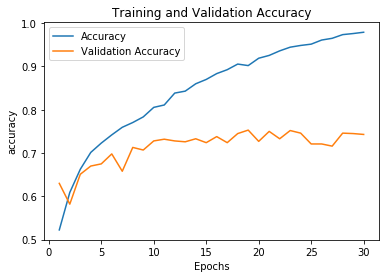

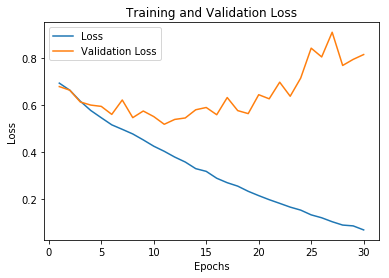

In [15]:
%matplotlib inline

from util import print_curves
print_curves(history)

These plots are characteristic of overfitting. Our training accuracy increases linearly over time, until it reaches nearly 100%, while our 
validation accuracy stalls at 70-72%. Our validation loss reaches its minimum after only five epochs then stalls, while the training loss 
keeps decreasing linearly until it reaches nearly 0.

## Tackle Overfitting - Data Augmentation

Overfitting is caused by having too few samples to learn from, rendering us unable to train a model able to generalize to new data. 
Given infinite data, our model would be exposed to every possible aspect of the data distribution at hand: we would never overfit. Data 
augmentation takes the approach of generating more training data from existing training samples, by "augmenting" the samples via a number 
of random transformations that yield believable-looking images. The goal is that at training time, our model would never see the exact same 
picture twice. This helps the model get exposed to more aspects of the data and generalize better.

In Keras, this can be done by configuring a number of random transformations to be performed on the images read by our `ImageDataGenerator` 
instance. Let's get started with an example:

In [16]:
datagen = ImageDataGenerator(
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

These are just a few of the options available (for more, see the Keras documentation). Let's quickly go over what we just wrote:

* `rotation_range` is a value in degrees (0-180), a range within which to randomly rotate pictures.
* `width_shift` and `height_shift` are ranges (as a fraction of total width or height) within which to randomly translate pictures 
vertically or horizontally.
* `shear_range` is for randomly applying shearing transformations.
* `zoom_range` is for randomly zooming inside pictures.
* `horizontal_flip` is for randomly flipping half of the images horizontally -- relevant when there are no assumptions of horizontal 
asymmetry (e.g. real-world pictures).
* `fill_mode` is the strategy used for filling in newly created pixels, which can appear after a rotation or a width/height shift.

Let's take a look at our augmented images:

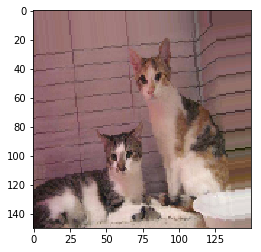

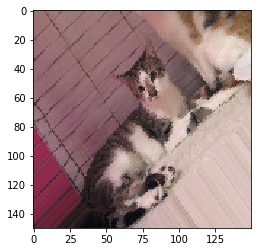

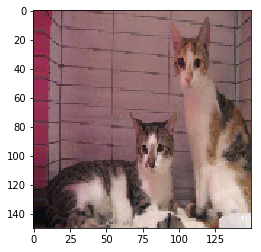

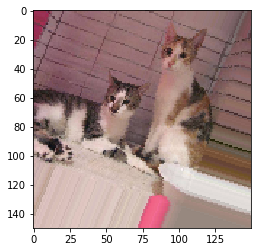

In [17]:
# This is module with image preprocessing utilities
from keras.preprocessing import image
import matplotlib.pyplot as plt

fnames = [os.path.join(train_cats_dir, fname) for fname in os.listdir(train_cats_dir)]

# We pick one image to "augment"
img_path = fnames[3]

# Read the image and resize it
img = image.load_img(img_path, target_size=(150, 150))

# Convert it to a Numpy array with shape (150, 150, 3)
x = image.img_to_array(img)

# Reshape it to (1, 150, 150, 3)
x = x.reshape((1,) + x.shape)

# The .flow() command below generates batches of randomly transformed images.
# It will loop indefinitely, so we need to `break` the loop at some point!
i = 0
for batch in datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 4 == 0:
        break

plt.show()

We'll also add Dropout to thte final Densely connected layer to further prevent overfitting.

In [18]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)


train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Found 2000 images belonging to 2 classes.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None

Let's run the model again.

In [19]:
model.compile(optimizer=optimizers.RMSprop(lr=1e-4),
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=50)

model.save(model_dir + '/cats_and_dogs_small_2.h5')

Epoch 1/30
100/100 [==============================] - 14s 138ms/step - loss: 0.6947 - acc: 0.5150 - val_loss: 0.6868 - val_acc: 0.5560
Epoch 2/30
100/100 [==============================] - 14s 136ms/step - loss: 0.6862 - acc: 0.5545 - val_loss: 0.6779 - val_acc: 0.5240
Epoch 3/30
100/100 [==============================] - 13s 131ms/step - loss: 0.6799 - acc: 0.5695 - val_loss: 0.6657 - val_acc: 0.5930
Epoch 4/30
100/100 [==============================] - 13s 128ms/step - loss: 0.6609 - acc: 0.6130 - val_loss: 0.6393 - val_acc: 0.6450
Epoch 5/30
100/100 [==============================] - 13s 128ms/step - loss: 0.6541 - acc: 0.6000 - val_loss: 0.6387 - val_acc: 0.6040
Epoch 6/30
100/100 [==============================] - 12s 124ms/step - loss: 0.6366 - acc: 0.6440 - val_loss: 0.6268 - val_acc: 0.6460
Epoch 7/30
100/100 [==============================] - 13s 134ms/step - loss: 0.6297 - acc: 0.6435 - val_loss: 0.6744 - val_acc: 0.5990
Epoch 8/30
100/100 [==============================] - 1

And Print the training results:

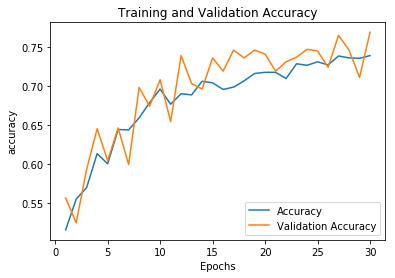

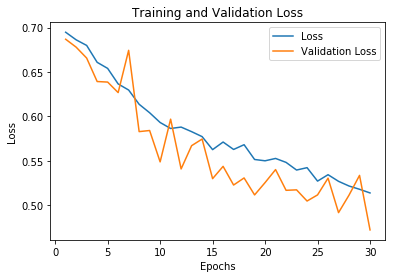

In [20]:
print_curves(history)

## Transfer Learning

A common and highly effective approach to deep learning on small image datasets is to leverage a pre-trained network. A pre-trained network is simply a saved network previously trained on a large dataset, typically on a large-scale image classification task. If this original dataset is large enough and general enough, then the spatial feature hierarchy learned by the pre-trained network can effectively act as a generic model of our visual world, and hence its features can prove useful for many different computer vision problems, even though these new problems might involve completely different classes from those of the original task. For instance, one might train a network on ImageNet (where classes are mostly animals and everyday objects) and then re-purpose this trained network for something as remote as identifying furniture items in images. Such portability of learned features across different problems is a key advantage of deep learning compared to many older shallow learning approaches, and it makes deep learning very effective for small-data problems.

In [21]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

In [22]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

## Adding Data Augmentation to VGG Base

In [23]:
from keras import models
from keras import layers

model = models.Sequential()
# here is where we insert the existing model
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_3 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


Designate the convolutionable base as static - it won't change in training.

In [24]:
print('number of Trainable weights before freezing:',
      len(model.trainable_weights))

('number of Trainable weights before freezing:', 30)


In [25]:
conv_base.trainable = False

In [26]:
# keep in mind these are the number of weight tensors, not number of total
# parameters
print('number of Trainable weights after freezing:', len(model.trainable_weights))

('number of Trainable weights after freezing:', 4)


In [27]:
model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

In [28]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=50)

Epoch 1/30
100/100 [==============================] - 15s 149ms/step - loss: 0.6182 - acc: 0.6455 - val_loss: 0.4608 - val_acc: 0.8230
Epoch 2/30
100/100 [==============================] - 13s 131ms/step - loss: 0.5036 - acc: 0.7735 - val_loss: 0.3710 - val_acc: 0.8550
Epoch 3/30
100/100 [==============================] - 13s 133ms/step - loss: 0.4410 - acc: 0.8085 - val_loss: 0.3318 - val_acc: 0.8740
Epoch 4/30
100/100 [==============================] - 13s 133ms/step - loss: 0.4125 - acc: 0.8200 - val_loss: 0.3122 - val_acc: 0.8740
Epoch 5/30
100/100 [==============================] - 13s 131ms/step - loss: 0.4115 - acc: 0.8215 - val_loss: 0.2987 - val_acc: 0.8880
Epoch 6/30
100/100 [==============================] - 13s 135ms/step - loss: 0.3751 - acc: 0.8385 - val_loss: 0.2927 - val_acc: 0.8890
Epoch 7/30
100/100 [==============================] - 13s 131ms/step - loss: 0.3678 - acc: 0.8425 - val_loss: 0.2807 - val_acc: 0.8920
Epoch 8/30
100/100 [==============================] - 1

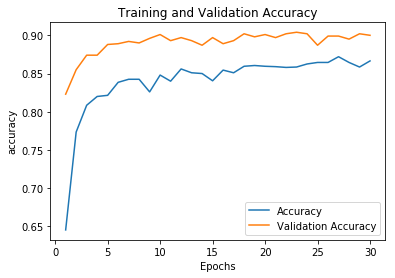

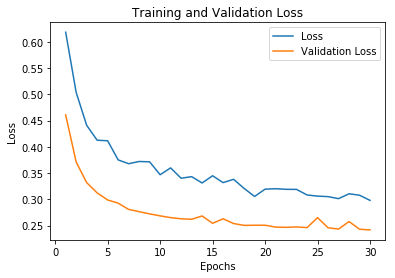

In [29]:
print_curves(history)

## Fine-tuning

Another widely used technique for model reuse, complementary to feature extraction, is _fine-tuning_. 
Fine-tuning consists in unfreezing a few of the top layers 
of a frozen model base used for feature extraction, and jointly training both the newly added part of the model (in our case, the 
fully-connected classifier) and these top layers. This is called "fine-tuning" because it slightly adjusts the more abstract 
representations of the model being reused, in order to make them more relevant for the problem at hand.

![fine-tuning VGG16](https://s3.amazonaws.com/book.keras.io/img/ch5/vgg16_fine_tuning.png)

In [30]:
conv_base.trainable = True

set_trainable = False

for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
        if set_trainable:
            layer.trainable = True
        else:
            layer.trainable = False

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])

In [ ]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    # change to 100
    epochs=100,
    validation_data=validation_generator,
    validation_steps=50)

Epoch 1/100
100/100 [==============================] - 17s 173ms/step - loss: 0.3183 - acc: 0.8660 - val_loss: 0.1617 - val_acc: 0.9350
Epoch 2/100
100/100 [==============================] - 16s 159ms/step - loss: 0.2301 - acc: 0.9135 - val_loss: 0.1352 - val_acc: 0.9460
Epoch 3/100
100/100 [==============================] - 15s 153ms/step - loss: 0.1743 - acc: 0.9310 - val_loss: 0.1142 - val_acc: 0.9520
Epoch 4/100
100/100 [==============================] - 15s 148ms/step - loss: 0.1477 - acc: 0.9360 - val_loss: 0.2793 - val_acc: 0.9130
Epoch 5/100
100/100 [==============================] - 14s 143ms/step - loss: 0.1322 - acc: 0.9450 - val_loss: 0.1022 - val_acc: 0.9650
Epoch 6/100
100/100 [==============================] - 14s 142ms/step - loss: 0.1185 - acc: 0.9550 - val_loss: 0.0974 - val_acc: 0.9680
Epoch 7/100
100/100 [==============================] - 15s 150ms/step - loss: 0.1132 - acc: 0.9530 - val_loss: 0.0818 - val_acc: 0.9690
Epoch 8/100
100/100 [===========================

In [ ]:
print_curves(history)

In [ ]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print(test_loss)
print(test_acc)